In [1]:
import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
%matplotlib inline
import collections
import copy
import time
import math
import inspect
import random
import pickle
# import GPUtil
import warnings
# import tiktoken
import torch
import torchvision
# import pandas as pd
# import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

from torch import nn
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)

# 设置打印选项，取消显示省略号
torch.set_printoptions(threshold=float('inf'))

In [2]:
# import torch

# # 查看是否有可用的 GPU
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"CUDA Available. Using GPU: {torch.cuda.get_device_name(device)}")
#     print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes")
#     print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes")
# else:
#     print("CUDA not available. Using CPU.")

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
#Ensure PyTorch can utilize CUDA
use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
# Define GPU device - We will run our model on GPU
mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mps_device

device(type='cuda', index=0)

In [6]:
# 查看显卡信息
!nvidia-smi

Fri Dec 20 09:45:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.35                 Driver Version: 553.35         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5880 Ada Gene...  WDDM  |   00000000:52:00.0  On |                    0 |
| 30%   36C    P8             19W /  285W |    6814MiB /  46068MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# 获取系统中可用的 CUDA 设备（即 GPU）的数量
torch.cuda.device_count()

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [8]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [9]:
try_gpu()

device(type='cuda', index=0)

# 🍔🍕🍔🍔🍕🍔🍕🍕Data🥗🥙🥪🌮🌑🌒🌓🌔🌕🌖☀

In [100]:
# 循环处理每个文件
for i in range(1, 4503):  # 从 1 到 6447
    input_file_path = os.path.join(r'F:\ptdatav2\1500v2', f'input-{i}.pt')
    
    # 检查文件是否存在
    if os.path.exists(input_file_path):
        # 加载张量
        input_tensor = torch.load(input_file_path)
        
        # 打印原始形状
        print(f'Original shape of input-{i}.pt: {input_tensor.shape}')
        
        # 改变形状, 使用 unsqueeze() 来添加一个新的维度
        input_tensor_reshaped = input_tensor.unsqueeze(-1)  # 在最后一个维度添加一个维度
        
        # 打印改变后的形状
        print(f'Reshaped shape of input-{i}.pt: {input_tensor_reshaped.shape}')
        
        # 保存新的张量
        torch.save(input_tensor_reshaped, input_file_path)
        print(f'Saved reshaped input-{i}.pt')
    else:
        print(f'File input-{i}.pt does not exist.')

print("Finished reshaping all files.")

Original shape of input-1.pt: torch.Size([4, 1])
Reshaped shape of input-1.pt: torch.Size([4, 1, 1])
Saved reshaped input-1.pt
Original shape of input-2.pt: torch.Size([4, 1])
Reshaped shape of input-2.pt: torch.Size([4, 1, 1])
Saved reshaped input-2.pt
Original shape of input-3.pt: torch.Size([4, 1])
Reshaped shape of input-3.pt: torch.Size([4, 1, 1])
Saved reshaped input-3.pt
Original shape of input-4.pt: torch.Size([4, 1])
Reshaped shape of input-4.pt: torch.Size([4, 1, 1])
Saved reshaped input-4.pt
Original shape of input-5.pt: torch.Size([4, 1])
Reshaped shape of input-5.pt: torch.Size([4, 1, 1])
Saved reshaped input-5.pt
Original shape of input-6.pt: torch.Size([4, 1])
Reshaped shape of input-6.pt: torch.Size([4, 1, 1])
Saved reshaped input-6.pt
Original shape of input-7.pt: torch.Size([4, 1])
Reshaped shape of input-7.pt: torch.Size([4, 1, 1])
Saved reshaped input-7.pt
Original shape of input-8.pt: torch.Size([4, 1])
Reshaped shape of input-8.pt: torch.Size([4, 1, 1])
Saved resh

In [101]:
torch.load(r'F:\ptdatav2\1500v2\input-1.pt').shape

torch.Size([4, 1, 1])

In [102]:
torch.load(r'F:\ptdatav2\1500v2\input-1.pt')

tensor([[[  1500.0000]],

        [[  -402.5000]],

        [[   350.0000]],

        [[112896.7969]]])

In [103]:
torch.load(r'F:\ptdatav2\1500v2\output-1.pt').shape

torch.Size([20, 20])

In [104]:
# 文件夹路径
save_folder = r'F:\ptdatav2\1500v2'
output_folder = r'F:\ptdatav2\1500v2'

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 遍历 1 到 6447 的每个文件
for i in range(1, 4503):  # 文件名从 input-1.pt 到 input-6447.pt
    # 加载张量
    input_tensor = torch.load(os.path.join(save_folder, f'input-{i}.pt'))
    
    # 删除第2个通道 (即索引为 2 的通道)，保留第0个、第1个和第3个通道
    modified_tensor = torch.cat((input_tensor[:2], input_tensor[3:]), dim=0)  # 保留通道 0, 1 和 3
    
    # 保存修改后的张量
    output_file = os.path.join(output_folder, f'input-{i}_modified.pt')
    torch.save(modified_tensor, output_file)
    
    print(f"Saved modified tensor: input-{i}_modified.pt")

print("Finished processing all tensors.")

Saved modified tensor: input-1_modified.pt
Saved modified tensor: input-2_modified.pt
Saved modified tensor: input-3_modified.pt
Saved modified tensor: input-4_modified.pt
Saved modified tensor: input-5_modified.pt
Saved modified tensor: input-6_modified.pt
Saved modified tensor: input-7_modified.pt
Saved modified tensor: input-8_modified.pt
Saved modified tensor: input-9_modified.pt
Saved modified tensor: input-10_modified.pt
Saved modified tensor: input-11_modified.pt
Saved modified tensor: input-12_modified.pt
Saved modified tensor: input-13_modified.pt
Saved modified tensor: input-14_modified.pt
Saved modified tensor: input-15_modified.pt
Saved modified tensor: input-16_modified.pt
Saved modified tensor: input-17_modified.pt
Saved modified tensor: input-18_modified.pt
Saved modified tensor: input-19_modified.pt
Saved modified tensor: input-20_modified.pt
Saved modified tensor: input-21_modified.pt
Saved modified tensor: input-22_modified.pt
Saved modified tensor: input-23_modified.

In [107]:
torch.load(r'F:\ptdatav2\1500v2\input-1_modified.pt')

tensor([[  -402.5000],
        [112896.7969]])

In [108]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav2\1500v2', f'input-{1}_modified.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 1])
Tensor device: cuda:0
Tensor content: tensor([[  -402.5000],
        [112896.7969]], device='cuda:0')


In [109]:
# 循环处理每个文件
for i in range(1, 4503):  # 从 1 到 6447
    output_file_path = os.path.join(r'F:\ptdatav2\1500v2', f'output-{i}.pt')
    
    # 检查文件是否存在
    if os.path.exists(output_file_path):
        # 加载张量
        output_tensor = torch.load(output_file_path)
        
        # 打印原始数据类型
        print(f'Original dtype of output-{i}.pt: {output_tensor.dtype}')
        
        # 确保数据类型是 float64
        if output_tensor.dtype == torch.float64:
            # 转换数据类型为 float32
            output_tensor_float32 = output_tensor.float()  # 等价于 output_tensor.to(torch.float32)
            
            # 打印转换后的数据类型
            print(f'Converted dtype of output-{i}.pt: {output_tensor_float32.dtype}')
            
            # 保存转换后的张量
            torch.save(output_tensor_float32, output_file_path)
            print(f'Saved converted output-{i}.pt')
        else:
            print(f'No conversion needed for output-{i}.pt, dtype is already {output_tensor.dtype}')
    else:
        print(f'File output-{i}.pt does not exist.')

print("Finished converting all files.")

Original dtype of output-1.pt: torch.float64
Converted dtype of output-1.pt: torch.float32
Saved converted output-1.pt
Original dtype of output-2.pt: torch.float64
Converted dtype of output-2.pt: torch.float32
Saved converted output-2.pt
Original dtype of output-3.pt: torch.float64
Converted dtype of output-3.pt: torch.float32
Saved converted output-3.pt
Original dtype of output-4.pt: torch.float64
Converted dtype of output-4.pt: torch.float32
Saved converted output-4.pt
Original dtype of output-5.pt: torch.float64
Converted dtype of output-5.pt: torch.float32
Saved converted output-5.pt
Original dtype of output-6.pt: torch.float64
Converted dtype of output-6.pt: torch.float32
Saved converted output-6.pt
Original dtype of output-7.pt: torch.float64
Converted dtype of output-7.pt: torch.float32
Saved converted output-7.pt
Original dtype of output-8.pt: torch.float64
Converted dtype of output-8.pt: torch.float32
Saved converted output-8.pt
Original dtype of output-9.pt: torch.float64
Con

In [110]:
tensor_raw_target = torch.load(os.path.join(r'F:\ptdatav2\1500v2', f'output-{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_target.dtype}")
print(f"Tensor shape: {tensor_raw_target.shape}")
print(f"Tensor device: {tensor_raw_target.device}")
print(f"Tensor content: {tensor_raw_target}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2104, 1203.2000,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2104, 1203.2104, 1203.2000, 1203.2104, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2104,
         1203.2104, 1203.2000, 1203.2000, 1203.2000, 

In [111]:
torch.load(r'F:\ptdatav2\1500v2\input-1_modified.pt').shape

torch.Size([2, 1])

In [112]:
channel_means = torch.zeros(2)  # 用来存储每个通道的均值
channel_stds = torch.zeros(2)   # 用来存储每个通道的标准差

# 用来存储所有样本的每个通道的数值
all_samples = torch.zeros(4502, 2) 

# 读取所有的输入张量
for i in range(1,4503):  
    # 加载第i个输入张量
    input_tensor = torch.load(os.path.join(r'F:\ptdatav2\1500v2', f'input-{i}_modified.pt'))
    
    # 将每个样本的通道值存储到 all_samples 张量中
    all_samples[i-1] = input_tensor.squeeze()  # squeeze 去掉(1, 1)维度，变成 (3,)

# 计算每个通道的均值和方差
channel_means = all_samples.mean(dim=0).to(mps_device)  # 沿着样本维度（第一个维度）求均值
channel_stds = all_samples.std(dim=0).to(mps_device)   # 沿着样本维度（第一个维度）求标准差

print("每个通道的均值:", channel_means)
print("每个通道的标准差:", channel_stds)

每个通道的均值: tensor([-1.2130e+02,  7.6434e+05], device='cuda:0')
每个通道的标准差: tensor([1.6247e+02, 9.4657e+05], device='cuda:0')


In [113]:
for i in range(1,4503):
    tensor_file = os.path.join(r'F:\ptdatav2\1500v2', f'input-{i}_modified.pt')
    tensor = torch.load(tensor_file).to(mps_device)
    tensor = (tensor - channel_means.view(2, 1, 1)) / channel_stds.view(2, 1, 1)

    output_file = os.path.join(r'F:\ptdatav2\1500v2_nor', f'normalized_input_{i}.pt')
    torch.save(tensor, output_file)

    print(f'Normalized tensor {i} saved to {output_file}')

Normalized tensor 1 saved to F:\ptdatav2\1500v2_nor\normalized_input_1.pt
Normalized tensor 2 saved to F:\ptdatav2\1500v2_nor\normalized_input_2.pt
Normalized tensor 3 saved to F:\ptdatav2\1500v2_nor\normalized_input_3.pt
Normalized tensor 4 saved to F:\ptdatav2\1500v2_nor\normalized_input_4.pt
Normalized tensor 5 saved to F:\ptdatav2\1500v2_nor\normalized_input_5.pt
Normalized tensor 6 saved to F:\ptdatav2\1500v2_nor\normalized_input_6.pt
Normalized tensor 7 saved to F:\ptdatav2\1500v2_nor\normalized_input_7.pt
Normalized tensor 8 saved to F:\ptdatav2\1500v2_nor\normalized_input_8.pt
Normalized tensor 9 saved to F:\ptdatav2\1500v2_nor\normalized_input_9.pt
Normalized tensor 10 saved to F:\ptdatav2\1500v2_nor\normalized_input_10.pt
Normalized tensor 11 saved to F:\ptdatav2\1500v2_nor\normalized_input_11.pt
Normalized tensor 12 saved to F:\ptdatav2\1500v2_nor\normalized_input_12.pt
Normalized tensor 13 saved to F:\ptdatav2\1500v2_nor\normalized_input_13.pt
Normalized tensor 14 saved to 

In [114]:
# 初始化一个空列表来存储所有张量
all_raw_target = []

for i in range(1,4503):
    raw_target = torch.load(os.path.join(r'F:\ptdatav2\1500v2', f'output-{i}.pt'))

    all_raw_target.append(raw_target)

all_raw_target_stack= torch.stack(all_raw_target) 
all_raw_target_stack.shape

# 计算全局均值和标准差
target_mean = all_raw_target_stack.mean()
target_std = all_raw_target_stack.std()
print(f"Global Mean: {target_mean.item()}, Global Standard Deviation: {target_std.item()}")

# 对每个张量进行 Z-score 归一化
target_normalized_tensors = (all_raw_target_stack - target_mean) / target_std 

Global Mean: 787.2450561523438, Global Standard Deviation: 596.531494140625


In [115]:
target_mean

tensor(787.2451)

In [116]:
target_std

tensor(596.5315)

In [117]:
target_normalized_tensors.shape[0]

4502

In [118]:
for i in range(target_normalized_tensors.shape[0]):  
    # 提取第 i 个 (20, 20) 的张量
    tensor_i = target_normalized_tensors[i]
    
    # 构建保存路径
    output_file_i = os.path.join(r"F:\ptdatav2\1500v2_nor", f'normalized_target_{i+1}.pt')
    
    # 保存张量
    torch.save(tensor_i, output_file_i)
    print(f"Saved normalized_target_{i+1}.pt")

Saved normalized_target_1.pt
Saved normalized_target_2.pt
Saved normalized_target_3.pt
Saved normalized_target_4.pt
Saved normalized_target_5.pt
Saved normalized_target_6.pt
Saved normalized_target_7.pt
Saved normalized_target_8.pt
Saved normalized_target_9.pt
Saved normalized_target_10.pt
Saved normalized_target_11.pt
Saved normalized_target_12.pt
Saved normalized_target_13.pt
Saved normalized_target_14.pt
Saved normalized_target_15.pt
Saved normalized_target_16.pt
Saved normalized_target_17.pt
Saved normalized_target_18.pt
Saved normalized_target_19.pt
Saved normalized_target_20.pt
Saved normalized_target_21.pt
Saved normalized_target_22.pt
Saved normalized_target_23.pt
Saved normalized_target_24.pt
Saved normalized_target_25.pt
Saved normalized_target_26.pt
Saved normalized_target_27.pt
Saved normalized_target_28.pt
Saved normalized_target_29.pt
Saved normalized_target_30.pt
Saved normalized_target_31.pt
Saved normalized_target_32.pt
Saved normalized_target_33.pt
Saved normalized_ta

In [119]:
tensor_process_target = torch.load(os.path.join(r'F:\ptdatav2\1500v2_nor', f'normalized_target_{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_process_target.dtype}")
print(f"Tensor shape: {tensor_process_target.shape}")
print(f"Tensor device: {tensor_process_target.device}")
print(f"Tensor content: {tensor_process_target}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973],
        [0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973],
        [0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973],
        [0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973],
        [0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973,
         0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0.6973, 0

In [120]:
tensor_process_input = torch.load(os.path.join(r'F:\ptdatav2\1500v2_nor', f'normalized_input_{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_process_input.dtype}")
print(f"Tensor shape: {tensor_process_input.shape}")
print(f"Tensor device: {tensor_process_input.device}")
print(f"Tensor content: {tensor_process_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 1])
Tensor device: cuda:0
Tensor content: tensor([[[-1.7308e+00],
         [ 6.9562e+02]],

        [[-8.0791e-01],
         [-6.8821e-01]]], device='cuda:0')


# 🍕🍔🍕🍕Consititute/Compose/Comprise Data loader 🌓🌔🌕🌖

In [10]:
import os
import shutil
import random
# 设置数据所在的目录
data_dir = r'F:\ENGINE_normalized_data'
input_dir = data_dir  
target_dir = data_dir 

# 设置比例
test_ratio = 0.01  # 10%作为测试集
val_ratio = 0.01   # 10%作为验证集

# 获取所有文件名
input_files = [f for f in os.listdir(input_dir) if f.startswith('normalized_input') and f.endswith('.pt')]
target_files = [f for f in os.listdir(target_dir) if f.startswith('normalized_target') and f.endswith('.pt')]

# 打印调试信息
print("输入文件列表:", input_files)
print("目标文件列表:", target_files)

# 确保input和target文件一一对应
assert len(input_files) == len(target_files), "input 和 target 文件数量不一致"

# 打乱文件顺序
data_pairs = list(zip(input_files, target_files))
random.shuffle(data_pairs)

# 计算数据集的划分
total_files = len(data_pairs)
test_size = int(total_files * test_ratio)
val_size = int(total_files * val_ratio)

# 划分数据集
test_data = data_pairs[:test_size]
val_data = data_pairs[test_size:test_size + val_size]
train_data = data_pairs[test_size + val_size:]

# 创建新的文件夹
def create_directory(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# 创建文件夹: train, val, test
create_directory(os.path.join(data_dir, 'train', 'inputs'))
create_directory(os.path.join(data_dir, 'train', 'targets'))
create_directory(os.path.join(data_dir, 'val', 'inputs'))
create_directory(os.path.join(data_dir, 'val', 'targets'))
create_directory(os.path.join(data_dir, 'test', 'inputs'))
create_directory(os.path.join(data_dir, 'test', 'targets'))

# 移动文件到相应文件夹
def move_files(data, subset):
    for input_file, target_file in data:
        input_src = os.path.join(input_dir, input_file)
        target_src = os.path.join(target_dir, target_file)
        
        input_dest = os.path.join(data_dir, subset, 'inputs', input_file)
        target_dest = os.path.join(data_dir, subset, 'targets', target_file)
        
        shutil.copy(input_src, input_dest)
        shutil.copy(target_src, target_dest)

# 移动文件
move_files(train_data, 'train')
move_files(val_data, 'val')
move_files(test_data, 'test')

print(f"数据划分完成：\n训练集：{len(train_data)}个文件\n验证集：{len(val_data)}个文件\n测试集：{len(test_data)}个文件")
print(f"数据划分完成：\n训练集：{len(train_data)}个文件\n验证集：{len(val_data)}个文件\n测试集：{len(test_data)}个文件")

输入文件列表: ['normalized_input_0.pt', 'normalized_input_1.pt', 'normalized_input_10.pt', 'normalized_input_100.pt', 'normalized_input_1000.pt', 'normalized_input_1001.pt', 'normalized_input_1002.pt', 'normalized_input_1003.pt', 'normalized_input_1004.pt', 'normalized_input_1005.pt', 'normalized_input_1006.pt', 'normalized_input_1007.pt', 'normalized_input_1008.pt', 'normalized_input_1009.pt', 'normalized_input_101.pt', 'normalized_input_1010.pt', 'normalized_input_1011.pt', 'normalized_input_1012.pt', 'normalized_input_1013.pt', 'normalized_input_1014.pt', 'normalized_input_1015.pt', 'normalized_input_1016.pt', 'normalized_input_1017.pt', 'normalized_input_1018.pt', 'normalized_input_1019.pt', 'normalized_input_102.pt', 'normalized_input_1020.pt', 'normalized_input_1021.pt', 'normalized_input_1022.pt', 'normalized_input_1023.pt', 'normalized_input_1024.pt', 'normalized_input_1025.pt', 'normalized_input_1026.pt', 'normalized_input_1027.pt', 'normalized_input_1028.pt', 'normalized_input_1029

In [11]:
# 定义源文件夹路径
input_folder = r'F:\ENGINE_normalized_data\test\inputs'
target_folder = r'F:\ENGINE_normalized_data\test\targets'
destination_folder = r'F:\ENGINE_normalized_data\test'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input_102.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1144.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_115.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1194.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1343.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1437.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1469.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1485.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1745.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1879.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_1936.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_2111.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_2127.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_2252.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_235.pt 已移动到 F:\ENGINE_normalized_data\test
文件 normalized_input_2509.pt 已移动到 F:\ENGINE_

In [12]:
input_folder = r'F:\ENGINE_normalized_data\train\inputs'
target_folder = r'F:\ENGINE_normalized_data\train\targets'
destination_folder = r'F:\ENGINE_normalized_data\train'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input_0.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_10.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_100.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1000.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1001.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1002.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1003.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1004.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1005.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1006.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1007.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1008.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1009.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_101.pt 已移动到 F:\ENGINE_normalized_data\train
文件 normalized_input_1010.pt 已移动到 F:

In [13]:
input_folder = r'F:\ENGINE_normalized_data\val\inputs'
target_folder = r'F:\ENGINE_normalized_data\val\targets'
destination_folder = r'F:\ENGINE_normalized_data\val'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input_1123.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1484.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1488.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1506.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_151.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1630.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1665.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1682.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1827.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_1986.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2025.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2130.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2256.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2287.pt 已移动到 F:\ENGINE_normalized_data\val
文件 normalized_input_2341.pt 已移动到 F:\ENGINE_normalized_data\

In [14]:
import re

In [15]:
test_dir_test_rename = r'F:\ENGINE_normalized_data\test'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_test_rename = [f for f in os.listdir(test_dir_test_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_test_rename = [f for f in pt_files_test_rename if f.startswith('normalized_input')]
target_files_test_rename = [f for f in pt_files_test_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_test_rename = sorted(input_files_test_rename, key=get_file_number)
sorted_target_files_test_rename = sorted(target_files_test_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_test_rename) == len(sorted_target_files_test_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_test_rename, target_file_test_rename) in enumerate(zip(sorted_input_files_test_rename, sorted_target_files_test_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_test_rename = f"input{i}.pt"
    new_target_filename_test_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_test_rename = os.path.join(test_dir_test_rename, input_file_test_rename)
    old_target_file_path_test_rename = os.path.join(test_dir_test_rename, target_file_test_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_test_rename = os.path.join(test_dir_test_rename, new_input_filename_test_rename)
    new_target_file_path_test_rename = os.path.join(test_dir_test_rename, new_target_filename_test_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_test_rename, new_input_file_path_test_rename)
    os.rename(old_target_file_path_test_rename, new_target_file_path_test_rename)
    
    print(f"Renamed {input_file_test_rename} to {new_input_filename_test_rename}")
    print(f"Renamed {target_file_test_rename} to {new_target_filename_test_rename}")

print("文件重命名完成！")

Renamed normalized_input_77.pt to input1.pt
Renamed normalized_target_77.pt to target1.pt
Renamed normalized_input_102.pt to input2.pt
Renamed normalized_target_102.pt to target2.pt
Renamed normalized_input_115.pt to input3.pt
Renamed normalized_target_115.pt to target3.pt
Renamed normalized_input_235.pt to input4.pt
Renamed normalized_target_235.pt to target4.pt
Renamed normalized_input_420.pt to input5.pt
Renamed normalized_target_420.pt to target5.pt
Renamed normalized_input_788.pt to input6.pt
Renamed normalized_target_788.pt to target6.pt
Renamed normalized_input_938.pt to input7.pt
Renamed normalized_target_938.pt to target7.pt
Renamed normalized_input_1144.pt to input8.pt
Renamed normalized_target_1144.pt to target8.pt
Renamed normalized_input_1194.pt to input9.pt
Renamed normalized_target_1194.pt to target9.pt
Renamed normalized_input_1343.pt to input10.pt
Renamed normalized_target_1343.pt to target10.pt
Renamed normalized_input_1437.pt to input11.pt
Renamed normalized_target_1

In [16]:
test_dir_val_rename = r'F:\ENGINE_normalized_data\val'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_val_rename = [f for f in os.listdir(test_dir_val_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_val_rename= [f for f in pt_files_val_rename if f.startswith('normalized_input')]
target_files_val_rename = [f for f in pt_files_val_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_val_rename = sorted(input_files_val_rename, key=get_file_number)
sorted_target_files_val_rename = sorted(target_files_val_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_val_rename) == len(sorted_target_files_val_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_val_rename, target_file_val_rename) in enumerate(zip(sorted_input_files_val_rename, sorted_target_files_val_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_val_rename = f"input{i}.pt"
    new_target_filename_val_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_val_rename = os.path.join(test_dir_val_rename, input_file_val_rename)
    old_target_file_path_val_rename = os.path.join(test_dir_val_rename, target_file_val_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_val_rename = os.path.join(test_dir_val_rename, new_input_filename_val_rename)
    new_target_file_path_val_rename = os.path.join(test_dir_val_rename, new_target_filename_val_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_val_rename, new_input_file_path_val_rename)
    os.rename(old_target_file_path_val_rename, new_target_file_path_val_rename)
    
    print(f"Renamed {input_file_val_rename} to {new_input_filename_val_rename}")
    print(f"Renamed {target_file_val_rename} to {new_target_filename_val_rename}")

print("文件重命名完成！")

Renamed normalized_input_2.pt to input1.pt
Renamed normalized_target_2.pt to target1.pt
Renamed normalized_input_55.pt to input2.pt
Renamed normalized_target_55.pt to target2.pt
Renamed normalized_input_151.pt to input3.pt
Renamed normalized_target_151.pt to target3.pt
Renamed normalized_input_240.pt to input4.pt
Renamed normalized_target_240.pt to target4.pt
Renamed normalized_input_318.pt to input5.pt
Renamed normalized_target_318.pt to target5.pt
Renamed normalized_input_357.pt to input6.pt
Renamed normalized_target_357.pt to target6.pt
Renamed normalized_input_428.pt to input7.pt
Renamed normalized_target_428.pt to target7.pt
Renamed normalized_input_529.pt to input8.pt
Renamed normalized_target_529.pt to target8.pt
Renamed normalized_input_538.pt to input9.pt
Renamed normalized_target_538.pt to target9.pt
Renamed normalized_input_543.pt to input10.pt
Renamed normalized_target_543.pt to target10.pt
Renamed normalized_input_585.pt to input11.pt
Renamed normalized_target_585.pt to ta

In [17]:
test_dir_train_rename = r'F:\ENGINE_normalized_data\train'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_train_rename = [f for f in os.listdir(test_dir_train_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_train_rename= [f for f in pt_files_train_rename if f.startswith('normalized_input')]
target_files_train_rename = [f for f in pt_files_train_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_train_rename = sorted(input_files_train_rename, key=get_file_number)
sorted_target_files_train_rename = sorted(target_files_train_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_train_rename) == len(sorted_target_files_train_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_train_rename, target_file_train_rename) in enumerate(zip(sorted_input_files_train_rename, sorted_target_files_train_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_train_rename = f"input{i}.pt"
    new_target_filename_train_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_train_rename = os.path.join(test_dir_train_rename, input_file_train_rename)
    old_target_file_path_train_rename = os.path.join(test_dir_train_rename, target_file_train_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_train_rename = os.path.join(test_dir_train_rename, new_input_filename_train_rename)
    new_target_file_path_train_rename = os.path.join(test_dir_train_rename, new_target_filename_train_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_train_rename, new_input_file_path_train_rename)
    os.rename(old_target_file_path_train_rename, new_target_file_path_train_rename)
    
    print(f"Renamed {input_file_train_rename} to {new_input_filename_train_rename}")
    print(f"Renamed {target_file_train_rename} to {new_target_filename_train_rename}")

print("文件重命名完成！")

Renamed normalized_input_0.pt to input1.pt
Renamed normalized_target_0.pt to target1.pt
Renamed normalized_input_1.pt to input2.pt
Renamed normalized_target_1.pt to target2.pt
Renamed normalized_input_3.pt to input3.pt
Renamed normalized_target_3.pt to target3.pt
Renamed normalized_input_4.pt to input4.pt
Renamed normalized_target_4.pt to target4.pt
Renamed normalized_input_5.pt to input5.pt
Renamed normalized_target_5.pt to target5.pt
Renamed normalized_input_6.pt to input6.pt
Renamed normalized_target_6.pt to target6.pt
Renamed normalized_input_7.pt to input7.pt
Renamed normalized_target_7.pt to target7.pt
Renamed normalized_input_8.pt to input8.pt
Renamed normalized_target_8.pt to target8.pt
Renamed normalized_input_9.pt to input9.pt
Renamed normalized_target_9.pt to target9.pt
Renamed normalized_input_10.pt to input10.pt
Renamed normalized_target_10.pt to target10.pt
Renamed normalized_input_11.pt to input11.pt
Renamed normalized_target_11.pt to target11.pt
Renamed normalized_input

# 🍕🍔🍕🍕Consititute/Compose/Comprise Data loader 🌓🌔🌕🌖

In [18]:
def load_data():
    train_inputs = []
    train_targets = []
    
    for i in range(1,6320):
        train_input_file = os.path.join(r"F:\ENGINE_normalized_data\train" , f"input{i}.pt")
        train_target_file = os.path.join(r"F:\ENGINE_normalized_data\train" , f'target{i}.pt')
        
        train_input_tensor = torch.load(train_input_file)  
        train_target_tensor = torch.load(train_target_file)
        
        train_inputs.append(train_input_tensor)
        train_targets.append(train_target_tensor)
        
    train_input_all = torch.stack(train_inputs).to(mps_device)
    train_target_all = torch.stack(train_targets).to(mps_device)
    
    train_dataset_ = TensorDataset(train_input_all, train_target_all)
    return train_dataset_,train_input_all,train_target_all

In [19]:
train_dataset_, train_input_all, train_target_all = load_data()

In [20]:
print(train_input_all.shape)
print(train_target_all.shape)
print(len(train_dataset_))

torch.Size([6319, 3, 1, 1])
torch.Size([6319, 20, 20])
6319


In [21]:
# DataLoader进行数据封装
train_loader_iter = DataLoader(dataset=train_dataset_, batch_size=256, shuffle=True,drop_last=True)

In [22]:
def test_load_data():
    test_inputs = []
    test_targets = []
    
    for i in range(1,65):
        test_input_file = os.path.join(r"F:\ENGINE_normalized_data\test" , f"input{i}.pt")
        test_target_file = os.path.join(r"F:\ENGINE_normalized_data\test" , f'target{i}.pt')
        
        test_input_tensor = torch.load(test_input_file)  
        test_target_tensor = torch.load(test_target_file)
        
        test_inputs.append(test_input_tensor)
        test_targets.append(test_target_tensor)
        
    test_input_all = torch.stack(test_inputs).to(mps_device)
    test_target_all = torch.stack(test_targets).to(mps_device)
    
    test_dataset_ = TensorDataset(test_input_all, test_target_all)
    return test_dataset_,test_input_all,test_target_all

In [23]:
def valid_load_data():
    valid_inputs = []
    valid_targets = []
    
    for i in range(1,65):
        valid_input_file = os.path.join(r"F:\ENGINE_normalized_data\val" , f"input{i}.pt")
        valid_target_file = os.path.join(r"F:\ENGINE_normalized_data\val" , f'target{i}.pt')
        
        valid_input_tensor = torch.load(valid_input_file)  
        valid_target_tensor = torch.load(valid_target_file)
        
        valid_inputs.append(valid_input_tensor)
        valid_targets.append(valid_target_tensor)
        
    valid_input_all = torch.stack(valid_inputs).to(mps_device)
    valid_target_all = torch.stack(valid_targets).to(mps_device)
    
    valid_dataset_ = TensorDataset(valid_input_all, valid_target_all)
    return valid_dataset_,valid_input_all,valid_target_all

In [24]:
test_dataset_, test_input_all, test_target_all = test_load_data()

In [25]:
valid_dataset_, valid_input_all, valid_target_all = valid_load_data()

In [26]:
test_loader_iter = DataLoader(dataset=test_dataset_, batch_size=64, shuffle=False,drop_last=True)

In [27]:
valid_loader_iter = DataLoader(dataset=valid_dataset_, batch_size=64, shuffle=False,drop_last=True)

In [28]:
len(test_loader_iter)

1

In [29]:
len(valid_loader_iter)

1

# 🍕🍔🍕🍕Construct Neural Network 🌓🌔🌕🌖

In [50]:
class BicubicLayer(nn.Module):
    def __init__(self, size=None, scale_factor=None, in_channels=None, out_channels=None,
                 kernel_size=None, padding=None, stride=None):
        super(BicubicLayer, self).__init__()
        
        self.size = size
        self.scale_factor = scale_factor
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding, stride=stride)
        
        self.elu = nn.ELU(inplace=True)
        
    def forward(self, X):
        Y = F.interpolate(X, size=self.size, scale_factor=self.scale_factor,mode='bicubic', align_corners=False)
        Y = self.conv(Y)
        Y = self.elu(Y)
        return Y

In [51]:
net_1 = BicubicLayer(size=(16, 16), in_channels=3, out_channels=8, kernel_size=2, padding=(0, 0), stride=(1,1))
net_2 = BicubicLayer(size=(32, 32), in_channels=8, out_channels=16, kernel_size=2, padding=(0, 0), stride=1)
net_3 = BicubicLayer(size=(72, 72), in_channels=16, out_channels=32, kernel_size=3, padding=(1, 1), stride=1) 

In [52]:
# 建立整体网络结构
net_block_1 = nn.Sequential(
    net_1,
    net_2,
    net_3,).to(try_gpu())

In [53]:
from torchsummary import summary
summary(net_block_1, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
Total params: 5,272
Trainable params: 5,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.19
Params size (MB): 0.02
Estimated Total Size (MB): 4.21
-----------------------------------------------

In [54]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides) #高宽不变
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y =  F.relu(self.bn1(self.conv1(X)))  
        Y = self.bn2(self.conv2(Y))         
        if self.conv3:
            X = self.conv3(X)                
        Y += X
        return F.relu(Y)

In [55]:
net_4 = Residual(32,48,use_1x1conv=True)
net_5 = Residual(48,56,use_1x1conv=True)
net_6 = Residual(56,64,use_1x1conv=True)

In [56]:
# 建立整体网络结构
net_block_2 = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    ).to(try_gpu())

In [57]:
from torchsummary import summary
summary(net_block_2, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

In [58]:
class Flatten_Module(nn.Module):
    def __init__(self):
        super(Flatten_Module, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 18 * 18, 400)

    def forward(self, x):

        flattened = self.flatten(x)  # Shape will be [batch_size, 64 * 9 * 9]
        linear_output = self.linear(flattened)  # Shape will be [batch_size, 1200]
        
        # Reshape to desired shape [batch_size, 20, 60]
        reshaped = linear_output.view( -1,20, 20)
        
        return reshaped

In [59]:
net_7 = Flatten_Module()

In [60]:
# 建立整体网络结构
net = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_7
    ).to(try_gpu())

In [61]:
from torchsummary import summary
summary(net, input_size=(3,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 15, 15]             104
               ELU-2            [-1, 8, 15, 15]               0
      BicubicLayer-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 16, 31, 31]             528
               ELU-5           [-1, 16, 31, 31]               0
      BicubicLayer-6           [-1, 16, 31, 31]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

# 🍕🍔🍕🍕Trainning 🌓🌔🌕🌖

In [62]:
num_epochs = 200
initial_lr = 0.0005
decay_rate = 0.9

In [63]:
loss = nn.MSELoss()
# 定义优化器
optimizer = torch.optim.AdamW(net.parameters(), lr=initial_lr)

# 定义学习率调度器：指数衰减
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

Epoch [1/200], traning_Loss: 1.3450, Learning Rate: 0.00050000
Epoch [1/200], validation_Loss: 0.9503, Learning Rate: 0.00050000
Epoch [2/200], traning_Loss: 0.2711, Learning Rate: 0.00050000
Epoch [2/200], validation_Loss: 0.3749, Learning Rate: 0.00050000
Epoch [3/200], traning_Loss: 0.1404, Learning Rate: 0.00050000
Epoch [3/200], validation_Loss: 0.1324, Learning Rate: 0.00050000
Epoch [4/200], traning_Loss: 0.1162, Learning Rate: 0.00050000
Epoch [4/200], validation_Loss: 0.1299, Learning Rate: 0.00050000
Epoch [5/200], traning_Loss: 0.1109, Learning Rate: 0.00045000
Epoch 5 completed. Learning Rate: 0.00045000
Epoch [5/200], validation_Loss: 0.2507, Learning Rate: 0.00045000
Epoch [6/200], traning_Loss: 0.1131, Learning Rate: 0.00045000
Epoch [6/200], validation_Loss: 0.3065, Learning Rate: 0.00045000
Epoch [7/200], traning_Loss: 0.1046, Learning Rate: 0.00045000
Epoch [7/200], validation_Loss: 0.1290, Learning Rate: 0.00045000
Epoch [8/200], traning_Loss: 0.0938, Learning Rate: 

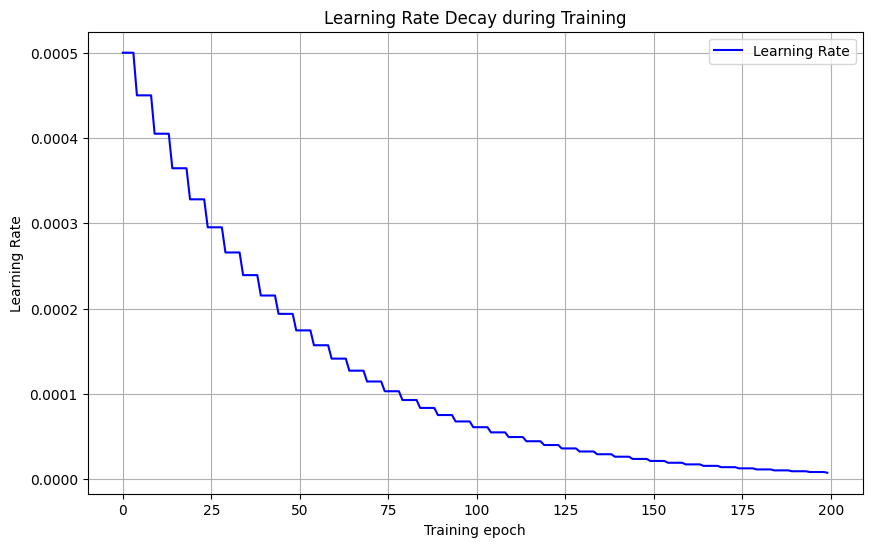

Training finished.


In [64]:
# 用于记录每个step的学习率
lr_history = []
best_val_loss = float('inf')  # 初始设为无穷大，以便后续能够找到更低的损失值
best_model_state = None

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    # Training phase
    net.train()
    train_loss = 0.0
    
    for X, y in train_loader_iter:
        optimizer.zero_grad()
        outputs = net(X)
        loss_value = loss(outputs, y)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
        
    train_losses.append(train_loss)  # Store the training loss  

    # 每经过5个epoch，学习率衰减一次
    if (epoch + 1) % 5 == 0:  # 每5个epoch更新一次学习率
        scheduler.step()

    # 打印每个epoch的学习率
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)  # 记录当前batch的学习率
    print(f"Epoch [{epoch+1}/{num_epochs}], traning_Loss: {train_loss/len(train_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")

    # 每5个epoch打印一次
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1} completed. Learning Rate: {current_lr:.8f}")

   
    # Validation phase
    net.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_val, y_val in valid_loader_iter:
            outputs = net(X_val)
            val_loss += loss(outputs, y_val).item()
            
    val_losses.append(val_loss)  # Store the validation loss
    
    # Check if this is the best model by validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = net.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], validation_Loss: {val_loss/len(valid_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")
    
# Save the best model state
torch.save(best_model_state, 'best_model.pth')

# 训练结束后，绘制学习率曲线
plt.figure(figsize=(10, 6))
plt.plot(lr_history, label='Learning Rate', color='b')
plt.xlabel('Training epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay during Training')
plt.legend()
plt.grid(True)
plt.show()

print("Training finished.")

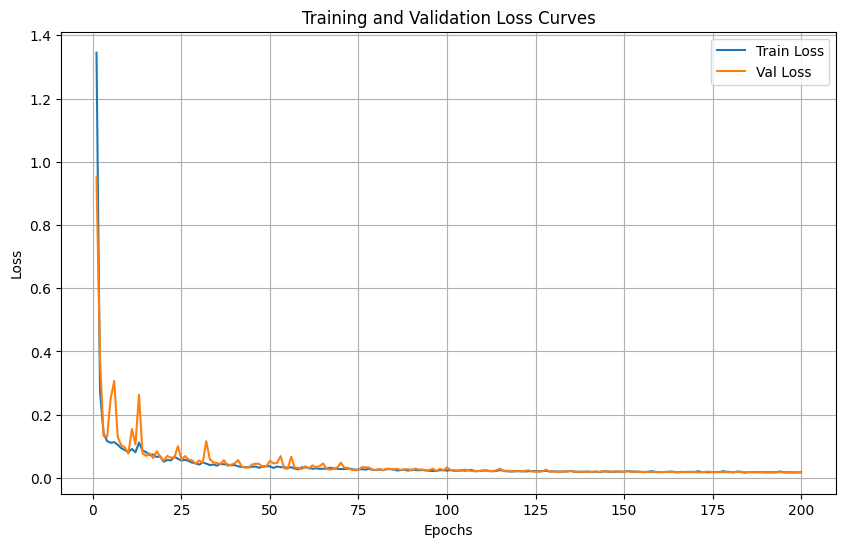

In [65]:
# Plotting the training and validation loss curves 
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), [loss / len(train_loader_iter) for loss in train_losses], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [loss / len(valid_loader_iter) for loss in val_losses], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Step 2: Load the best model state
best_model = torch.load('best_model.pth')

# Step 3: Load state dict into the model
net.load_state_dict(best_model)

# Step 4: Set the model to evaluation mode
net.eval()

# Step 5: Evaluate on the test set
test_loss = 0.0

with torch.no_grad():
    for X_test, y_test in test_loader_iter:
        outputs = net(X_test)
        test_loss += loss(outputs, y_test).item() * X_test.size(0)

# Calculate average test loss
test_loss = test_loss / len(test_loader_iter.dataset)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0123


In [68]:
target_mean=837.4973
target_std=617.3029

In [73]:
# Step 2: 加载 input{i}.pt 和 target{i}.pt 文件夹中的所有文件
test_folder = r'F:\ENGINE_normalized_data\test'  # 输入文件所在目录
input_files = sorted([f for f in os.listdir(test_folder) if f.startswith('input') and f.endswith('.pt')])  # 查找所有 input{i}.pt 文件
target_files = sorted([f for f in os.listdir(test_folder) if f.startswith('target') and f.endswith('.pt')])  # 查找所有 target{i}.pt 文件

# # Step 3: 只处理前 600 个文件
# input_files = input_files[:200]  # 只选择前 600 个 input 文件
# target_files = target_files[:200]  # 只选择前 600 个 target 文件

# Step 4: 初始化保存结果的列表
A_values = []  # 用于存储 A 值
predicted_outputs = []  # 用于存储预测结果
true_outputs = []  # 用于存储真实结果

# Step 5: 逐个加载 input 和 target 文件，进行预测并计算 A
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)  # 确保模型在正确的设备上

for input_file, target_file in zip(input_files, target_files):
    # 加载输入和目标张量
    input_tensor = torch.load(os.path.join(test_folder, input_file)).to(device)
    output_tensor = torch.load(os.path.join(test_folder, target_file)).to(device)
    
    # 进行预测
    with torch.no_grad():
        predicted_output = net(input_tensor.unsqueeze(0)) * target_std + target_mean   # 预测结果
        output_tensor = output_tensor * target_std + target_mean  # 转换目标张量到原始尺度
    
    # 计算 A 值
    A = (output_tensor - predicted_output) / output_tensor  # A 计算公式

    # 将预测结果、真实结果和 A 值转回 CPU 并转为 NumPy 数组 (去除 batch 维度)
    predicted_outputs.append(predicted_output.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    true_outputs.append(output_tensor.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    A_values.append(A.squeeze().cpu().numpy())  # 计算 A 值，并去掉 batch 维度，得到 (20, 20)

# Step 6: 将结果转换为 NumPy 数组，形状应为 (600, 20, 20)
predicted_outputs = np.array(predicted_outputs)  # 形状为 (600, 20, 20)
true_outputs = np.array(true_outputs)  # 形状为 (600, 20, 20)
A_matrix = np.array(A_values)  # 形状为 (600, 20, 20)

# 打印输出的形状
print(f"Predicted outputs shape: {predicted_outputs.shape}")  # 打印预测输出的形状
print(f"True outputs shape: {true_outputs.shape}")  # 打印真实输出的形状
print(f"A matrix shape: {A_matrix.shape}")  # 打印 A 的形状

# Step 7: 输出最后一个预测结果和真实结果
print(f"Last predicted_output: {predicted_outputs[0]}")  
print(f"Last true output_tensor: {true_outputs[0]}")  
print(f"Last A: {A_matrix[0]}") 

Predicted outputs shape: (64, 20, 20)
True outputs shape: (64, 20, 20)
A matrix shape: (64, 20, 20)
Last predicted_output: [[ 907.279    736.1929   904.5567   914.5017   941.5214   941.12976
   939.5206  1128.6995   906.5098   721.0179   741.4007   731.33496
   916.7415   884.44183  857.1775   821.34644  815.8197   911.18225
  1084.8616   884.2241 ]
 [ 644.4267   912.1507   889.5196  1116.2787  1056.365   1193.8542
  1154.6768  1085.7932   913.2107   916.63855  730.7516   920.85583
   840.43604 1012.706    905.3624   917.483    899.2023   991.62976
   834.4922   951.17596]
 [ 717.58167  918.11    1062.4448  1060.843   1023.9215  1004.34827
  1005.31726  966.4238  1017.57935  915.2298   733.00116 1115.258
   930.7143   905.80145  907.21893 1157.0958   896.43005  892.9347
   933.5634   919.3606 ]
 [1026.1595   906.4591   922.6099   998.5731   908.8952   908.2835
   901.2703  1136.0205   926.84894  906.3163  1042.2273   871.73285
   905.6616  1019.35693  920.7214   915.03235  903.2495  10

In [74]:
true_outputs = true_outputs.reshape(64, 400)
A_matrix = A_matrix.reshape(64, 400)
predicted_outputs = predicted_outputs.reshape(64, 400)

# 打印调整后的形状
print(f"Reshaped shape of true_outputs: {true_outputs.shape}")
print(f"Reshaped shape of A_matrix: {A_matrix.shape}")
print(f"Reshaped shape of predicted_outputs: {predicted_outputs.shape}")

Reshaped shape of true_outputs: (64, 400)
Reshaped shape of A_matrix: (64, 400)
Reshaped shape of predicted_outputs: (64, 400)


In [77]:
r2_values = np.zeros((64, 1))

# 对每一行计算 R² 值
for i in range(64):
    y_true = true_outputs[i, :]  # 取 true_outputs 的第 i 行
    y_pred = predicted_outputs[i, :]  # 取 predicted_outputs 的第 i 行
    
    # 计算均值
    mean_true = np.mean(y_true)
    
    # 计算总平方和 (SS_tot) 和残差平方和 (SS_res)
    ss_tot = np.sum((y_true - mean_true) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # 计算 R²
    r2 = 1 - (ss_res / ss_tot)
    
    # 存储 R² 值
    r2_values[i] = r2

# 打印结果
print(f"R² values (600, 1) matrix:\n{r2_values}")

R² values (600, 1) matrix:
[[ 0.91711572]
 [ 0.37030637]
 [ 0.42173147]
 [ 0.51445428]
 [ 0.51647457]
 [ 0.38216108]
 [ 0.35111499]
 [ 0.39545017]
 [ 0.67410579]
 [ 0.70443186]
 [ 0.77186055]
 [ 0.88514777]
 [ 0.55049637]
 [ 0.75089826]
 [ 0.0958814 ]
 [ 0.19972551]
 [ 0.38156617]
 [ 0.39282191]
 [ 0.41172671]
 [ 0.38909107]
 [ 0.10619336]
 [ 0.27177685]
 [ 0.91604472]
 [ 0.28988326]
 [ 0.68462622]
 [ 0.66583675]
 [ 0.93402977]
 [ 0.94304601]
 [ 0.91852399]
 [ 0.88076054]
 [ 0.83735797]
 [ 0.97377736]
 [ 0.97293927]
 [ 0.80303927]
 [ 0.97827278]
 [ 0.97617057]
 [ 0.97109129]
 [ 0.98183969]
 [ 0.97062377]
 [ 0.9797564 ]
 [ 0.85815784]
 [ 0.48970336]
 [ 0.60592633]
 [ 0.63632813]
 [ 0.5372977 ]
 [ 0.44773877]
 [ 0.24831164]
 [-0.14738965]
 [-3.7568469 ]
 [-3.09439516]
 [ 0.66129547]
 [ 0.94993053]
 [ 0.9570642 ]
 [ 0.92988339]
 [ 0.92636938]
 [ 0.30684435]
 [ 0.75047283]
 [ 0.7281152 ]
 [ 0.87613544]
 [ 0.23299807]
 [ 0.58714521]
 [ 0.36991704]
 [ 0.51378763]
 [ 0.43132687]]


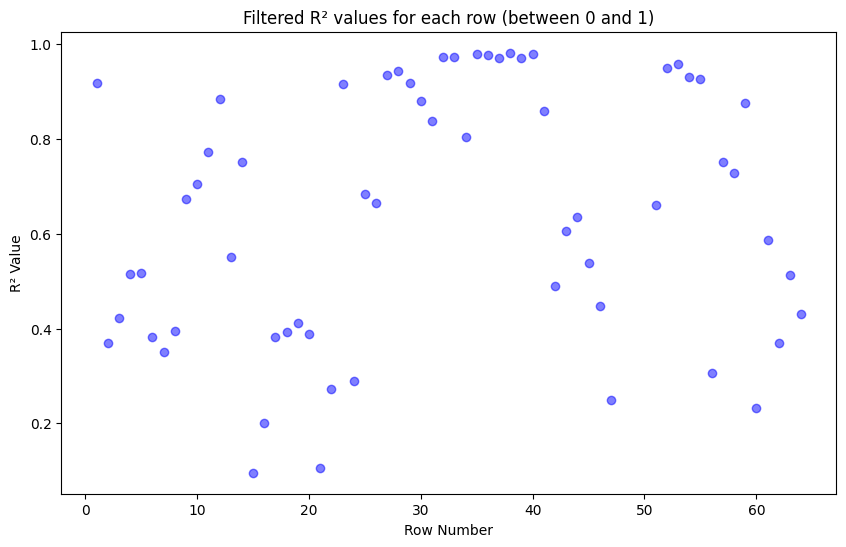

In [78]:
x = np.arange(1, 65)  # 行号从 1 到 600

# 将 r2_values 展平为一维数组
r2_values_flat = r2_values.flatten()

# 筛选出 R² 值在 0 到 1 之间的部分
valid_indices = (r2_values_flat >= 0) & (r2_values_flat <= 1)
filtered_r2_values = r2_values_flat[valid_indices]
filtered_x = x[valid_indices]

# 创建散点图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(filtered_x, filtered_r2_values, color='blue', alpha=0.5)  # 绘制散点图，设置颜色和透明度

# 设置图表标题和轴标签
plt.title('Filtered R² values for each row (between 0 and 1)')
plt.xlabel('Row Number')
plt.ylabel('R² Value')

# 显示图形
plt.show()

In [83]:
# Step 1: 加载训练好的模型
best_model = torch.load('best_model.pth')  # 假设 'best_model.pth' 是你保存的最佳模型
net.load_state_dict(best_model)  # 将模型参数加载到模型中
net.eval()  # 设置模型为评估模式

# Step 2: 加载 input2.pt 和 output2.pt
input_tensor = torch.load(r'F:\ENGINE_normalized_data\test\input1.pt')  # 加载 input2.pt
output_tensor = torch.load(r'F:\ENGINE_normalized_data\test\target1.pt')  # 加载 output2.pt

# 检查输入张量的形状
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")

# 将输入张量转移到正确的设备上 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
output_tensor = output_tensor.to(device)
net.to(device)  # 确保模型也在相同设备上

# Step 3: 对 input2.pt 进行预测
with torch.no_grad():  # 禁用梯度计算，因为我们只做推理
    predicted_output = (net(input_tensor.unsqueeze(0)) * target_std)+ target_mean  # 假设输入是 [batch_size, channels, height, width]
    output_tensor   =output_tensor * target_std + target_mean
    
# 打印预测结果
print(f"Predicted output: {predicted_output}")
print(f"True output: {True_output}")

Input tensor shape: torch.Size([3, 1, 1])
Output tensor shape: torch.Size([20, 20])
Predicted output: tensor([[[ 907.2790,  736.1929,  904.5567,  914.5017,  941.5214,  941.1298,
           939.5206, 1128.6995,  906.5098,  721.0179,  741.4007,  731.3350,
           916.7415,  884.4418,  857.1775,  821.3464,  815.8197,  911.1823,
          1084.8616,  884.2241],
         [ 644.4267,  912.1507,  889.5196, 1116.2787, 1056.3650, 1193.8542,
          1154.6768, 1085.7932,  913.2107,  916.6385,  730.7516,  920.8558,
           840.4360, 1012.7060,  905.3624,  917.4830,  899.2023,  991.6298,
           834.4922,  951.1760],
         [ 717.5817,  918.1100, 1062.4448, 1060.8430, 1023.9215, 1004.3483,
          1005.3173,  966.4238, 1017.5793,  915.2298,  733.0012, 1115.2581,
           930.7143,  905.8015,  907.2189, 1157.0958,  896.4301,  892.9347,
           933.5634,  919.3606],
         [1026.1595,  906.4591,  922.6099,  998.5731,  908.8952,  908.2835,
           901.2703, 1136.0205,  926.84

NameError: name 'True_output' is not defined

In [84]:
Predicted_output_reverse=predicted_output * target_std + target_mean
Predicted_output_reverse

tensor([[[560903.4375, 455291.5000, 559223.0000, 565362.0625, 582041.4375,
          581799.6250, 580806.3125, 697587.0000, 560428.6875, 445923.9375,
          458506.3125, 452292.7188, 566744.6875, 546806.0000, 529975.6875,
          507857.0625, 504445.3750, 563312.9375, 670525.6875, 546671.6250],
         [398643.9688, 563910.8125, 549940.5625, 689919.5625, 652934.6875,
          737807.1875, 713622.8125, 671100.8125, 564565.1250, 566681.1250,
          451932.5938, 569284.5000, 519641.1250, 625983.8750, 559720.3750,
          567202.4375, 555917.6875, 612973.4375, 515971.9688, 588001.1875],
         [443802.7500, 567589.5000, 656687.8125, 655699.0000, 632907.2500,
          620824.6250, 621422.7500, 597413.7500, 628992.1875, 565811.5000,
          453321.2500, 689289.5625, 575370.1250, 559991.3750, 560866.3750,
          715116.1250, 554206.3750, 552048.6875, 577128.9375, 568361.5000],
         [634288.8125, 560397.3750, 570367.3125, 617259.6250, 561901.1875,
          561523.5625,

In [85]:
output_tensor_reverse=output_tensor * target_std + target_mean
output_tensor_reverse

tensor([[540197.4375, 448246.9062, 559369.8125, 551254.5625, 559600.5625,
         564027.9375, 562698.7500, 697847.1875, 559356.1250, 434462.8750,
         448651.2188, 442569.9062, 550702.5625, 527388.6875, 511173.6250,
         494125.0312, 492891.3125, 537978.8750, 667982.1875, 528912.6250],
        [388656.6250, 546654.9375, 538100.8125, 668023.2500, 652872.4375,
         729673.6250, 707267.3125, 662468.0625, 545549.2500, 559128.5625,
         445766.1875, 555894.1875, 510116.9688, 617405.8125, 530784.8125,
         551029.3125, 531395.1250, 603208.1875, 509148.3125, 571065.8750],
        [429946.8438, 555167.8125, 734663.0625, 653591.5625, 633374.0625,
         597281.6250, 615480.3125, 585830.5625, 623844.5000, 555169.6875,
         449603.9375, 687956.2500, 562282.1250, 528541.5625, 527087.7500,
         723870.1875, 525311.3750, 528331.8125, 566977.5000, 549225.7500],
        [622728.1250, 545459.7500, 589475.1875, 610192.5000, 527578.9375,
         525535.4375, 527503.3750, 

In [86]:
output_tensor_reverse-Predicted_output_reverse

tensor([[[-2.0706e+04, -7.0446e+03,  1.4681e+02, -1.4108e+04, -2.2441e+04,
          -1.7772e+04, -1.8108e+04,  2.6019e+02, -1.0726e+03, -1.1461e+04,
          -9.8551e+03, -9.7228e+03, -1.6042e+04, -1.9417e+04, -1.8802e+04,
          -1.3732e+04, -1.1554e+04, -2.5334e+04, -2.5435e+03, -1.7759e+04],
         [-9.9873e+03, -1.7256e+04, -1.1840e+04, -2.1896e+04, -6.2250e+01,
          -8.1336e+03, -6.3555e+03, -8.6328e+03, -1.9016e+04, -7.5526e+03,
          -6.1664e+03, -1.3390e+04, -9.5242e+03, -8.5781e+03, -2.8936e+04,
          -1.6173e+04, -2.4523e+04, -9.7652e+03, -6.8237e+03, -1.6935e+04],
         [-1.3856e+04, -1.2422e+04,  7.7975e+04, -2.1074e+03,  4.6681e+02,
          -2.3543e+04, -5.9424e+03, -1.1583e+04, -5.1477e+03, -1.0642e+04,
          -3.7173e+03, -1.3333e+03, -1.3088e+04, -3.1450e+04, -3.3779e+04,
           8.7541e+03, -2.8895e+04, -2.3717e+04, -1.0151e+04, -1.9136e+04],
         [-1.1561e+04, -1.4938e+04,  1.9108e+04, -7.0671e+03, -3.4322e+04,
          -3.5988e+04,

In [87]:
(output_tensor_reverse-Predicted_output_reverse)/output_tensor_reverse

tensor([[[-3.8330e-02, -1.5716e-02,  2.6246e-04, -2.5592e-02, -4.0102e-02,
          -3.1509e-02, -3.2180e-02,  3.7284e-04, -1.9175e-03, -2.6380e-02,
          -2.1966e-02, -2.1969e-02, -2.9130e-02, -3.6818e-02, -3.6782e-02,
          -2.7791e-02, -2.3441e-02, -4.7091e-02, -3.8077e-03, -3.3576e-02],
         [-2.5697e-02, -3.1566e-02, -2.2003e-02, -3.2778e-02, -9.5348e-05,
          -1.1147e-02, -8.9860e-03, -1.3031e-02, -3.4856e-02, -1.3508e-02,
          -1.3833e-02, -2.4088e-02, -1.8671e-02, -1.3894e-02, -5.4515e-02,
          -2.9351e-02, -4.6148e-02, -1.6189e-02, -1.3402e-02, -2.9656e-02],
         [-3.2227e-02, -2.2375e-02,  1.0614e-01, -3.2244e-03,  7.3702e-04,
          -3.9417e-02, -9.6550e-03, -1.9772e-02, -8.2516e-03, -1.9169e-02,
          -8.2680e-03, -1.9381e-03, -2.3277e-02, -5.9503e-02, -6.4085e-02,
           1.2093e-02, -5.5005e-02, -4.4890e-02, -1.7904e-02, -3.4841e-02],
         [-1.8565e-02, -2.7385e-02,  3.2415e-02, -1.1582e-02, -6.5056e-02,
          -6.8479e-02,

In [88]:
A=(output_tensor_reverse-Predicted_output_reverse)/output_tensor_reverse

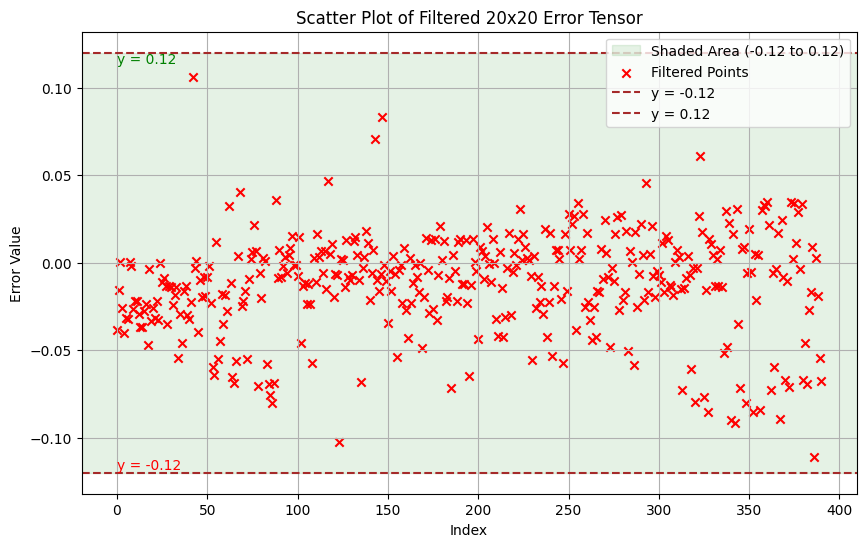

In [89]:
# Step 1: Flatten the tensor to 1x400
flattened_A = A.flatten()

# Step 2: Remove values that are not within [-0.12, 0.12]
flattened_A = flattened_A[(flattened_A >= -0.12) & (flattened_A <= 0.12)]

# Step 3: Visualize the filtered values as a scatter plot
filtered_A_numpy = flattened_A.cpu().numpy()

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Add shading for the region between -0.12 and 0.12
plt.axhspan(-0.12, 0.12, color='green', alpha=0.1, label='Shaded Area (-0.12 to 0.12)')

# Scatter plot for filtered values
plt.scatter(range(len(filtered_A_numpy)), filtered_A_numpy, color='red', marker='x', alpha=1, label='Filtered Points')

# Add horizontal lines at y = -0.12 and y = 0.12
plt.axhline(y=-0.12, color='brown', linestyle='--', label='y = -0.12')
plt.axhline(y=0.12, color='brown', linestyle='--', label='y = 0.12')

# Add text labels for the horizontal lines
plt.text(0, -0.12, 'y = -0.12', color='r', verticalalignment='bottom', horizontalalignment='left')
plt.text(0, 0.12, 'y = 0.12', color='g', verticalalignment='top', horizontalalignment='left')

# Label the axes and add a title
plt.xlabel('Index')
plt.ylabel('Error Value')
plt.title('Scatter Plot of Filtered 20x20 Error Tensor')

# Show grid, legend, and plot
plt.grid(True)
plt.legend()
plt.show()

In [91]:
y_true = output_tensor_reverse.view(-1)  # 真实值
y_pred = Predicted_output_reverse.view(-1)  # 预测值

# 计算均值
y_mean = y_true.mean()

# 计算R²
ss_total = torch.sum((y_true - y_mean) ** 2)  # 总平方和
ss_residual = torch.sum((y_true - y_pred) ** 2)  # 残差平方和

r2 = 1 - (ss_residual / ss_total)  # R²公式
print(f"R²: {r2.item()}")

R²: 0.9171157479286194


In [13]:
# 加载 .npy 文件
true_outputs = np.load(r'C:\Users\ROG\true_outputs.npy')
A_matrix = np.load(r'C:\Users\ROG\A_matrix.npy')
predicted_outputs = np.load(r'C:\Users\ROG\predicted_outputs.npy')

# 打印每个数组的形状
print(f"Shape of true_outputs: {true_outputs.shape}")
print(f"Shape of A_matrix: {A_matrix.shape}")
print(f"Shape of predicted_outputs: {predicted_outputs.shape}")

Shape of true_outputs: (600, 20, 20)
Shape of A_matrix: (600, 20, 20)
Shape of predicted_outputs: (600, 20, 20)


In [14]:
true_outputs = true_outputs.reshape(600, 400)
A_matrix = A_matrix.reshape(600, 400)
predicted_outputs = predicted_outputs.reshape(600, 400)

# 打印调整后的形状
print(f"Reshaped shape of true_outputs: {true_outputs.shape}")
print(f"Reshaped shape of A_matrix: {A_matrix.shape}")
print(f"Reshaped shape of predicted_outputs: {predicted_outputs.shape}")

Reshaped shape of true_outputs: (600, 400)
Reshaped shape of A_matrix: (600, 400)
Reshaped shape of predicted_outputs: (600, 400)


In [15]:
r2_values = np.zeros((600, 1))

# 对每一行计算 R² 值
for i in range(600):
    y_true = true_outputs[i, :]  # 取 true_outputs 的第 i 行
    y_pred = predicted_outputs[i, :]  # 取 predicted_outputs 的第 i 行
    
    # 计算均值
    mean_true = np.mean(y_true)
    
    # 计算总平方和 (SS_tot) 和残差平方和 (SS_res)
    ss_tot = np.sum((y_true - mean_true) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # 计算 R²
    r2 = 1 - (ss_res / ss_tot)
    
    # 存储 R² 值
    r2_values[i] = r2

# 打印结果
print(f"R² values (600, 1) matrix:\n{r2_values}")

R² values (600, 1) matrix:
[[ 9.56753906e-01]
 [ 5.45769155e-01]
 [ 4.80167329e-01]
 [ 3.86358142e-01]
 [ 6.06748015e-01]
 [ 9.62153375e-01]
 [ 5.72073281e-01]
 [ 9.30171788e-01]
 [ 8.49575132e-01]
 [ 7.64842972e-01]
 [ 4.99988377e-01]
 [ 4.75271761e-01]
 [ 4.91830051e-01]
 [ 4.66283083e-01]
 [-8.17564964e+00]
 [-4.98815656e-01]
 [ 6.23591334e-01]
 [ 5.28164506e-01]
 [ 9.71298702e-01]
 [ 5.36333650e-01]
 [ 6.49898142e-01]
 [ 9.70697567e-01]
 [ 9.03606169e-01]
 [ 5.43714970e-01]
 [ 8.99462432e-01]
 [ 4.26297784e-01]
 [ 6.62373692e-01]
 [ 1.63073063e-01]
 [ 9.82341647e-01]
 [ 6.80900723e-01]
 [ 9.76167893e-01]
 [ 9.74254698e-01]
 [ 7.85062313e-01]
 [ 9.71090896e-01]
 [ 6.19699329e-01]
 [ 4.41272497e-01]
 [ 9.17518944e-01]
 [ 8.77072059e-01]
 [ 1.86949193e-01]
 [ 3.77417445e-01]
 [ 6.19604141e-01]
 [ 9.58051886e-01]
 [ 5.91527909e-01]
 [ 5.87135911e-01]
 [ 8.80679943e-01]
 [ 6.66846007e-01]
 [ 4.37031031e-01]
 [ 5.43094844e-01]
 [ 7.09375739e-02]
 [ 9.39923111e-01]
 [ 9.70617052e-01]
 [-6

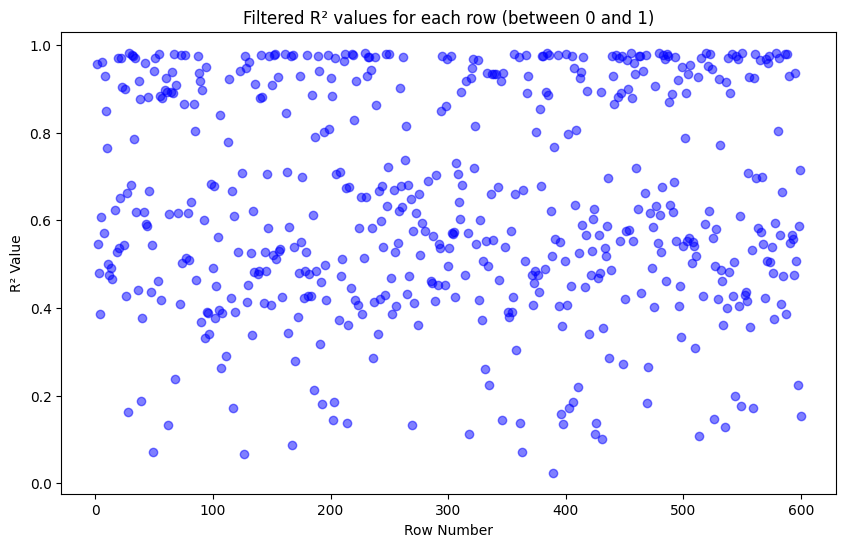

In [19]:
x = np.arange(1, 601)  # 行号从 1 到 600

# 将 r2_values 展平为一维数组
r2_values_flat = r2_values.flatten()

# 筛选出 R² 值在 0 到 1 之间的部分
valid_indices = (r2_values_flat >= 0) & (r2_values_flat <= 1)
filtered_r2_values = r2_values_flat[valid_indices]
filtered_x = x[valid_indices]

# 创建散点图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(filtered_x, filtered_r2_values, color='blue', alpha=0.5)  # 绘制散点图，设置颜色和透明度

# 设置图表标题和轴标签
plt.title('Filtered R² values for each row (between 0 and 1)')
plt.xlabel('Row Number')
plt.ylabel('R² Value')

# 显示图形
plt.show()

In [20]:
r2_values_flat = r2_values.flatten()

# 统计 R² 值大于 0.9 的数量
count_above_90 = np.sum(r2_values_flat > 0.9)

# 输出结果
print(f"Number of R² values above 0.9: {count_above_90}")

Number of R² values above 0.9: 141


In [263]:
# Step 1: 加载训练好的模型
best_model = torch.load('best_model.pth')  # 假设 'best_model.pth' 是你保存的最佳模型
net.load_state_dict(best_model)  # 将模型参数加载到模型中
net.eval()  # 设置模型为评估模式

# Step 2: 加载 input2.pt 和 output2.pt
input_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\input-1.pt')  # 加载 input2.pt
output_tensor = torch.load(r'C:\Users\wang.zhuo17\ENGINE_normalized_data_shuffled\test\output-1.pt')  # 加载 output2.pt

# 检查输入张量的形状
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")

# 将输入张量转移到正确的设备上 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
output_tensor = output_tensor.to(device)
net.to(device)  # 确保模型也在相同设备上

# Step 3: 对 input2.pt 进行预测
with torch.no_grad():  # 禁用梯度计算，因为我们只做推理
    predicted_output = net(input_tensor.unsqueeze(0))  # 假设输入是 [batch_size, channels, height, width]
    
# 打印预测结果
print(f"Predicted output: {predicted_output}")

# # Step 4: 对比预测结果与实际输出
# # 假设你是做回归任务或者是对比连续值，可以用 L2 Loss（均方误差）来比较
# loss_fn = nn.MSELoss()  # 均方误差损失函数
# loss_value = loss_fn(predicted_output, output_tensor.unsqueeze(0))  # 扩展维度匹配 batch size
# print(f"Prediction Loss (MSE): {loss_value.item()}")

Input tensor shape: torch.Size([3, 1, 1])
Output tensor shape: torch.Size([20, 20])
Predicted output: tensor([[[0.9088, 1.2262, 2.3607, 2.4372, 0.4752, 1.2918, 0.6362, 2.4895,
          2.3841, 2.3730, 1.6477, 1.7292, 2.4810, 2.3712, 1.6445, 1.4493,
          1.3148, 2.5510, 2.5338, 1.7411],
         [1.5806, 2.2803, 1.3754, 1.5082, 1.3202, 0.7797, 2.3534, 1.4039,
          1.0970, 1.1729, 1.5911, 1.1307, 1.9405, 2.2344, 2.3001, 1.8452,
          1.9340, 2.2197, 1.5851, 1.6383],
         [1.7335, 2.1847, 2.7336, 2.4782, 1.6201, 0.7805, 1.5329, 2.4780,
          2.5507, 2.2674, 1.6675, 1.7605, 2.6346, 2.3044, 2.4592, 2.5146,
          2.4626, 2.5476, 2.6456, 2.3611],
         [1.8445, 1.9551, 1.4531, 2.1706, 2.2921, 2.2486, 2.1089, 2.0737,
          1.4604, 2.1764, 2.1610, 1.9311, 2.3421, 2.4618, 2.6442, 1.8920,
          2.5658, 2.3500, 2.1587, 2.2383],
         [1.2333, 2.7023, 2.6749, 2.5816, 2.5835, 2.2405, 2.4425, 2.4373,
          2.5300, 2.5901, 0.7898, 2.5275, 2.6697, 2.6290, 2.

In [264]:
output_tensor

tensor([[ 0.9315,  1.2474,  2.4214,  2.4461,  0.5093,  1.4063,  0.6646,  2.5219,
          2.4294,  2.4088,  1.6182,  1.6824,  2.5036,  2.4195,  1.5950,  1.3713,
          1.3204,  2.5701,  2.5812,  1.7385],
        [ 1.5059,  2.3119,  1.4771,  1.5639,  1.3342,  0.8320,  2.4067,  1.4827,
          1.1110,  1.1671,  1.5970,  1.0955,  1.8808,  2.2301,  2.2890,  1.8612,
          1.8819,  2.1792,  1.5004,  1.5893],
        [ 1.6744,  2.1689,  2.8512,  2.4269,  1.6739,  0.7851,  1.5057,  2.5352,
          2.7370,  2.3121,  1.6347,  1.8096,  2.6609,  2.4181,  2.4963,  2.5541,
          2.4675,  2.4222,  2.6972,  2.3435],
        [ 1.7708,  2.0020,  1.4934,  2.1455,  2.4201,  2.3233,  2.2109,  2.1597,
          1.4878,  2.2192,  2.2083,  1.9595,  2.3802,  2.5028,  2.6815,  1.9061,
          2.6031,  2.3174,  2.3659,  2.1925],
        [ 1.1440,  2.7348,  2.7297,  2.5554,  2.6259,  2.2699,  2.5050,  2.5030,
          2.5817,  2.6459,  0.7846,  2.5647,  2.7201,  2.4169,  2.7165,  2.7277,
      

In [265]:
Predicted_output_reverse=predicted_output * target_std + target_mean
Predicted_output_reverse

tensor([[[1398.5162, 1594.4495, 2294.7788, 2341.9573, 1130.8516, 1634.9506,
          1230.2239, 2374.2925, 2309.2263, 2302.3579, 1854.6558, 1904.9624,
          2369.0291, 2301.2434, 1852.6305, 1732.1777, 1649.1519, 2412.2668,
          2401.6023, 1912.2839],
         [1813.2352, 2245.1189, 1686.5227, 1768.5076, 1652.4731, 1318.7788,
          2290.2646, 1704.1331, 1514.6919, 1561.5435, 1819.6868, 1535.4657,
          2035.3464, 2216.8044, 2257.3586, 1976.5593, 2031.3804, 2207.7371,
          1815.9885, 1848.8518],
         [1907.6023, 2186.0959, 2524.9856, 2367.2700, 1837.5894, 1319.3026,
          1783.7502, 2367.1492, 2412.0256, 2237.1895, 1866.8293, 1924.2527,
          2463.8508, 2260.0066, 2355.5491, 2389.7642, 2357.6440, 2410.1594,
          2470.6387, 2295.0154],
         [1976.0984, 2044.3669, 1734.5306, 2177.4128, 2252.4331, 2225.5391,
          2139.3040, 2117.5918, 1739.0100, 2181.0181, 2171.4629, 2029.5627,
          2283.2759, 2357.1958, 2469.7800, 2005.4573, 2421.3567, 

In [266]:
output_tensor_reverse=output_tensor * target_std + target_mean
output_tensor_reverse

tensor([[1412.4893, 1607.5338, 2332.2268, 2347.4910, 1151.9064, 1705.5853,
         1247.7650, 2394.2800, 2337.2021, 2324.4507, 1836.3920, 1876.0479,
         2382.9871, 2331.0464, 1822.0900, 1683.9792, 1652.5593, 2424.0156,
         2430.9043, 1910.6648],
        [1767.1033, 2264.6594, 1749.3096, 1802.9031, 1661.1183, 1351.1062,
         2323.1868, 1752.7820, 1523.3409, 1557.9612, 1823.3055, 1513.7274,
         1998.5437, 2214.1572, 2250.5061, 1986.4148, 1999.1929, 2182.7444,
         1763.7222, 1818.6062],
        [1871.1331, 2176.3850, 2597.5664, 2335.6328, 1870.8079, 1322.1321,
         1766.9929, 2402.4841, 2527.0244, 2264.7617, 1846.5792, 1954.5391,
         2480.0652, 2330.2024, 2378.4844, 2414.1262, 2360.7202, 2332.7505,
         2502.5037, 2284.1772],
        [1930.6035, 2073.3499, 1759.3564, 2161.9419, 2331.4119, 2271.6709,
         2202.2620, 2170.6702, 1755.8940, 2207.3965, 2200.7007, 2047.1199,
         2306.7798, 2382.4561, 2492.8245, 2014.1626, 2444.4202, 2268.0457,
    

In [267]:
output_tensor_reverse-Predicted_output_reverse

tensor([[[    13.9730,     13.0844,     37.4480,      5.5337,     21.0548,
              70.6348,     17.5411,     19.9875,     27.9758,     22.0928,
             -18.2638,    -28.9146,     13.9580,     29.8030,    -30.5405,
             -48.1985,      3.4075,     11.7488,     29.3020,     -1.6191],
         [   -46.1320,     19.5405,     62.7869,     34.3955,      8.6451,
              32.3274,     32.9221,     48.6489,      8.6490,     -3.5823,
               3.6188,    -21.7383,    -36.8027,     -2.6472,     -6.8525,
               9.8555,    -32.1875,    -24.9927,    -52.2664,    -30.2456],
         [   -36.4692,     -9.7109,     72.5808,    -31.6372,     33.2185,
               2.8295,    -16.7573,     35.3350,    114.9988,     27.5723,
             -20.2501,     30.2864,     16.2144,     70.1958,     22.9353,
              24.3621,      3.0762,    -77.4089,     31.8650,    -10.8381],
         [   -45.4949,     28.9829,     24.8258,    -15.4709,     78.9788,
              46.1318,

In [123]:
# Step 2: Load the best model state
best_model = torch.load('best_model.pth')

# Step 3: Load state dict into the model
net.load_state_dict(best_model)

# Step 4: Set the model to evaluation mode
net.eval()

# Step 5: Evaluate on the test set
test_loss = 0.0

with torch.no_grad():
    for X_test, y_test in test_loader_iter:
        outputs = net(X_test)
        test_loss += loss(outputs, y_test).item() * X_test.size(0)

# Calculate average test loss
test_loss = test_loss / len(test_loader_iter.dataset)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0248


In [124]:
outputs.shape

torch.Size([256, 20, 20])

In [129]:
outputs

tensor([[[    -0.2611,     -0.1655,      1.2973,      1.3124,     -0.1064,
               0.4147,     -0.0392,      1.5228,      1.4478,      0.3282,
               0.3165,      0.2600,      1.5071,      1.5649,      0.2468,
               0.1242,      0.0123,      1.3123,      1.3348,      0.0831],
         [    -0.2409,      0.0280,     -0.1217,      0.2094,      0.2938,
              -0.0938,      0.3642,      0.5324,      0.1402,      0.0297,
               0.3386,      0.0729,      0.2670,      0.6094,      0.3051,
               0.3481,      0.3069,      0.1992,     -0.0649,     -0.1038],
         [    -0.0454,      0.2564,      0.9861,      1.3130,      0.1393,
              -0.1817,      0.1981,      1.2425,      1.3587,      0.3160,
               0.3639,      0.6842,      1.5911,      1.5173,      1.0513,
               1.1387,      0.7572,      1.2549,      1.2776,      0.3549],
         [     0.2037,      0.6989,     -0.0539,     -0.2256,      0.1338,
               0.1396,

In [128]:
# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)
global_mean = 5.00992488861084
global_std = 3.157698392868042

# 逆 Z-score 归一化公式
outputs_original = outputs * target_std + target_mean

# 查看逆归一化后的 outputs 张量
print(outputs_original.shape)
print(outputs_original)

torch.Size([256, 20, 20])
tensor([[[ 676.3435,  735.3627, 1638.3450, 1647.6492,  771.7860, 1093.5076,
           813.2999, 1777.5127, 1731.2329, 1040.0996, 1032.8694,  998.0167,
          1767.8638, 1803.5308,  989.8725,  914.1452,  845.1093, 1647.5837,
          1661.4990,  888.8061],
         [ 688.7969,  854.7537,  762.3448,  966.7789, 1018.8466,  779.6143,
          1062.3308, 1166.1672,  924.0190,  855.8291, 1046.5402,  882.5114,
          1002.3473, 1213.6570, 1025.8234, 1052.3594, 1026.9402,  960.4373,
           797.4507,  773.4100],
         [ 809.5003,  995.7535, 1446.2131, 1648.0378,  923.4617,  725.3173,
           959.8136, 1604.4951, 1676.2146, 1032.5665, 1062.1466, 1259.8503,
          1819.7079, 1774.1531, 1486.4635, 1540.3921, 1304.8892, 1612.1744,
          1626.1589, 1056.5756],
         [ 963.2695, 1268.9363,  804.2058,  698.2361,  920.1180,  923.6671,
          1188.4613, 1078.8335,  864.3426, 1393.0291, 1446.8660, 1365.2753,
          1046.8721, 1513.4562, 1689.85

In [ ]:
C:\Users\wang.zhuo17\V1\test\input
C:\Users\wang.zhuo17\V1\test\target
C:\Users\wang.zhuo17\V1\test